In [2]:
import torch 
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
# words=pd.read_csv("data/amharic_names.csv")
# am_words=words["in_am"].tolist()0
am_words=open("data/english_names.txt","r").read().splitlines()


In [4]:
chrs=sorted(set(list("".join(am_words))))
stoi={s:i+1 for i,s in enumerate(chrs)}
stoi["."]=0
itos={i:s for s,i in stoi.items()}


In [5]:
block_size=3
def build_dataset(am_words):
    X,Y=[],[]
    for w in am_words:
        context=[0]*block_size
        for ch in w +".":
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
            # print("".join(itos[i] for i in context),'---->',itos[ix])
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    return X,Y

In [6]:
random.seed(42)
random.shuffle(am_words)
n1=int(0.8*(len(am_words)))
n2=int(0.9*(len(am_words)))

Xtr,Ytr=build_dataset(am_words[:n1])      #80
Xval,Yval=build_dataset(am_words[n1:n2])  #10
Xte,Yte=build_dataset(am_words[n2:])      #10

In [7]:
n_embed=10  # dimensionality of the char embedding vector
n_hidden=200
vocab_size=len(itos)

g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embed), generator=g)
W1=torch.randn((n_embed*block_size,n_hidden), generator=g) 
b1=torch.randn(n_hidden, generator=g) 
W2=torch.randn((n_hidden,vocab_size), generator=g)  
b2=torch.randn(vocab_size, generator=g)    
parameters=[C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True

11897


- if the first loss is very high the initialization is messed up
- each char has 188 pr of 1/188


this is what we expect on the first loss
```
(-torch.tensor(1/188.0).log())

---> 5.2364

```

if it is high we have to normaize the logits

```
logits=h@W2+b2
```


In [8]:
max_step=200000

batch_size=32
lossi=[]

for i in range(max_step):

    #minibatch
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix]

    #forward pass
    embed=C[Xb]   #embed the char into vectors
    embed_cat=embed.view(embed.shape[0],-1) 
    hid_preact=embed_cat@W1+b1    #hidden layer
    h=torch.tanh(hid_preact)  #hidden layer
    logits=h@W2+b2 #output layer
    loss=F.cross_entropy(logits,Yb)

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    lr=0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    
    #track stats
    if i%1000==0:
        print(f"{i:7d}/{max_step:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    

      0/ 200000: 27.8817
   1000/ 200000: 4.1518
   2000/ 200000: 3.0123
   3000/ 200000: 2.8102
   4000/ 200000: 2.3621
   5000/ 200000: 2.4691
   6000/ 200000: 2.3880
   7000/ 200000: 2.9116
   8000/ 200000: 2.5351
   9000/ 200000: 2.4647
  10000/ 200000: 2.8341
  11000/ 200000: 2.0572
  12000/ 200000: 2.4659
  13000/ 200000: 2.4050
  14000/ 200000: 2.9435
  15000/ 200000: 2.2845
  16000/ 200000: 2.5545
  17000/ 200000: 2.7456
  18000/ 200000: 2.3867
  19000/ 200000: 2.3120
  20000/ 200000: 2.5523
  21000/ 200000: 2.6717
  22000/ 200000: 2.1023
  23000/ 200000: 2.1336
  24000/ 200000: 2.9781
  25000/ 200000: 2.2987
  26000/ 200000: 2.4137
  27000/ 200000: 2.6827
  28000/ 200000: 2.2783
  29000/ 200000: 3.1179
  30000/ 200000: 2.8717
  31000/ 200000: 2.6393
  32000/ 200000: 2.5242
  33000/ 200000: 2.5427
  34000/ 200000: 2.2871
  35000/ 200000: 2.5331
  36000/ 200000: 2.1098
  37000/ 200000: 2.1807
  38000/ 200000: 2.8674
  39000/ 200000: 2.1043
  40000/ 200000: 2.0855
  41000/ 200000

In [ ]:
'''
- Here for tanh linear activation functions the range is between -1 and 1
- In the saturation regions of tanh, the derivative (gradient) is very small.
During backpropagation, these small gradients can cause the updates to the weights 
to be very small, slowing down the training process or even causing it to stall.
'''
plt.hist(h.view(-1).tolist(),50)

plt.hist(hid_preact.view(-1).tolist(),50)

# - if the entire column is white it is dead neuron

plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99 ,cmap="gray", interpolation="nearest")


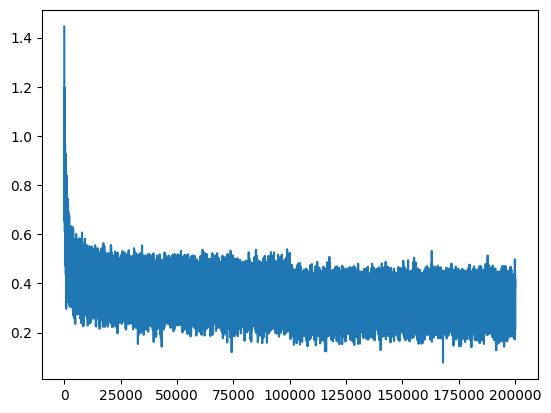

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]    
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.125401020050049
val 2.1713311672210693


- as you can see the validation loss is higher than the train loss this show us our model is overfitting.

In [11]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nah.
yam.
rensleighdrae.
caileed.
elin.
shy.
jen.
eden.
estanaraelyn.
malke.
cayshuberlyni.
jest.
jair.
jenipanthono.
ubelleda.
kylynn.
els.
